# LSTM Model

In [1]:
import pandas as pd 
from sklearn.model_selection  import train_test_split
import numpy as np 
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import lag_plot
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load and PreProcess 

In [2]:
data = pd.read_csv('data/PMS_data.csv',nrows=500000)

In [3]:
data.head()

,Flow,Occupy,Speed
0,133.0,0.0603,65.8
1,210.0,0.0589,69.6
2,124.0,0.0358,65.8
3,145.0,0.0416,69.6
4,206.0,0.0493,69.4


In [4]:
new_set = data[['Flow','Occupy']].copy()

In [5]:
new_set.head()

,Flow,Occupy
0,133.0,0.0603
1,210.0,0.0589
2,124.0,0.0358
3,145.0,0.0416
4,206.0,0.0493


In [6]:
new_set['Flow'] = np.around(new_set['Flow'])
new_set.head()

,Flow,Occupy
0,133.0,0.0603
1,210.0,0.0589
2,124.0,0.0358
3,145.0,0.0416
4,206.0,0.0493


In [7]:
new_set_plot = new_set.values

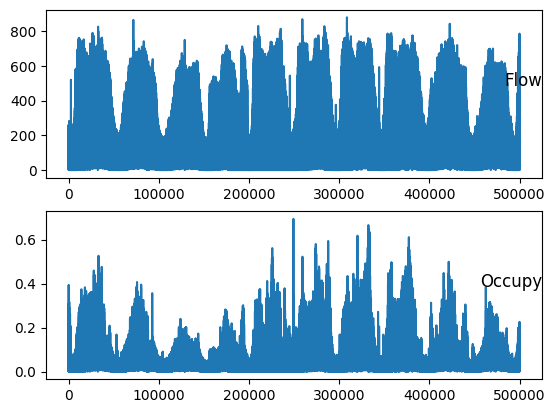

In [8]:
groups = [0, 1]
i = 1
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(new_set_plot[:, group])
    plt.title(new_set.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler


In [10]:
scaler = StandardScaler()

In [11]:
new_set

,Flow,Occupy
0,133.0,0.0603
1,210.0,0.0589
2,124.0,0.0358
3,145.0,0.0416
4,206.0,0.0493
...,...,...
499995,68.0,0.0228
499996,190.0,0.0668
499997,144.0,0.0408
499998,204.0,0.0483


In [12]:
x = new_set.Occupy.values

y = new_set.Flow.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

In [13]:
x_train = scaler.fit_transform(x_train.reshape(-1,1))
y_train = scaler.fit_transform(y_train.reshape(-1,1))
x_test = scaler.fit_transform(x_test.reshape(-1,1))
y_test = scaler.fit_transform(y_test.reshape(-1,1))

In [14]:
#x_train = x_train.reshape(-1,1)
x_train.shape

(375000, 1)

In [15]:
#x_test = x_test.reshape(-1,1)
x_test.shape

(125000, 1)

In [16]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM ,Dense , Dropout
import tensorflow as tf

model = Sequential()
model.add(LSTM(50,activation="relu",return_sequences=True,input_shape=(x_train.shape[0],x_train.shape[1])))
model.add(LSTM(50,return_sequences = False,activation="relu"))
model.add(Dense(50))
model.add(Dropout(0.2))
model.add(Dense(1))


In [17]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,activation="relu", return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,activation="relu")),
  tf.keras.layers.Dense(50),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

In [18]:
loss_fn= tf.losses.Huber()
tf.keras.backend.clear_session()
model.compile(loss=loss_fn, optimizer=tf.keras.optimizers.Adam())
history = model.fit(x_train, y_train, epochs=5, batch_size=50, validation_data=(x_test, y_test), shuffle=False)
     

Epoch 1/5
7500/7500 [==============================] - 50s 6ms/step - loss: 0.1763 - val_loss: 0.1678
Epoch 2/5
7500/7500 [==============================] - 47s 6ms/step - loss: 0.1749 - val_loss: 0.1674
Epoch 3/5
7500/7500 [==============================] - 47s 6ms/step - loss: 0.1747 - val_loss: 0.1674
Epoch 4/5
7500/7500 [==============================] - 47s 6ms/step - loss: 0.1748 - val_loss: 0.1686
Epoch 5/5
7500/7500 [==============================] - 47s 6ms/step - loss: 0.1745 - val_loss: 0.1673


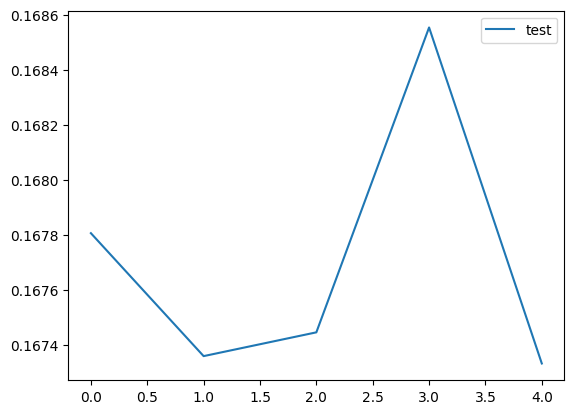

In [30]:
# plot history
#plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        33792     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              263168    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 50)                12850     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [21]:
# make a prediction
y_pred = model.predict(x_test)


3907/3907 [==============================] - 11s 3ms/step


In [22]:
y_pred.shape

(125000, 1)

In [23]:
y_prednormal=scaler.inverse_transform(y_pred)
y_testnormal=scaler.inverse_transform(y_test)

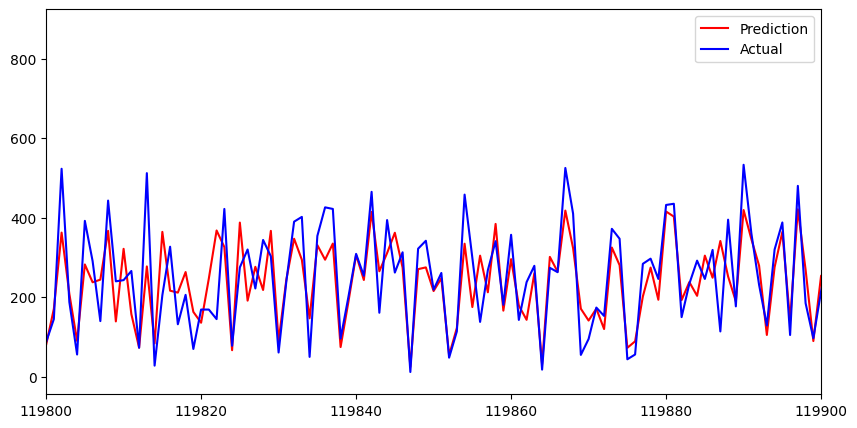

In [24]:
plt.figure(figsize=(10,5))
plt.plot(y_prednormal,color = 'red',label = 'Prediction')
plt.plot(y_testnormal,color = 'blue',label = 'Actual')
plt.legend()
plt.xlim(119800,119900)
plt.show()

In [31]:
r2s = metrics.r2_score(y_true=y_testnormal,y_pred=y_prednormal)
r2s

0.6431178632963634

In [32]:
rmse = sqrt(metrics.mean_squared_error(y_testnormal, y_prednormal))
rmse

84.72784153447402

In [34]:
mae = metrics.mean_absolute_error(y_true=y_testnormal,y_pred=y_prednormal)
mae

62.16401889406204

In [36]:
mse = metrics.mean_squared_error(y_true=y_testnormal,y_pred=y_prednormal)
mse

7178.807131090941